In [ ]:
from PIL import Image
import colorsys
import math

#frame parameters
width = 500 #pixels
x = -0.65
y = 0
xRange = 3.4
aspectRatio = 4/3 

precision = 500

height = round(width / aspectRatio)
yRange = xRange / aspectRatio
minX = x - xRange / 2
maxX = x + xRange / 2
minY = y - yRange / 2
maxY = y + yRange / 2

img = Image.new('RGB', (width, height), color = 'black')
pixels = img.load()

def logColor(distance, base, const, scale):
    color = -1 * math.log(distance, base)
    rgb = colorsys.hsv_to_rgb(const + scale * color,0.8,0.9)
    return tuple(round(i * 255) for i in rgb)

def powerColor(distance, exp, const, scale):
    color = distance**exp
    rgb = colorsys.hsv_to_rgb(const + scale * color,1 - 0.6 * color,0.9)
    return tuple(round(i * 255) for i in rgb)

for row in range(height):
    for col in range(width):
        x = minX + col * xRange / width
        y = maxY - row * yRange / height
        oldX = x
        oldY = y
        for i in range(precision + 1):
            a = x*x - y*y #real component of z^2
            b = 2 * x * y #imaginary component of z^2
            x = a + oldX #real component of new z
            y = b + oldY #imaginary component of new z
            if x*x + y*y > 4:
                break
        if i < precision:
            distance = (i + 1) / (precision + 1)
            rgb = powerColor(distance, 0.2, 0.27, 1.0)
            pixels[col,row] = rgb
        index = row * width + col + 1

img.save('output.png')

In [15]:
import numpy as np
import matplotlib.pyplot as plt
import random
import warnings
warnings.simplefilter("ignore")

def complex_matrix(xmin, xmax, ymin, ymax, pixeldensity):
    re = np.linspace(xmin, xmax, int((xmax - xmin) * pixeldensity))
    im = np.linspace(ymin, ymax, int((ymax - ymin) * pixeldensity))
    return re[np.newaxis, :] + im[:, np.newaxis] * 1j

def is_stable(c, num_iterations):
    z = 0
    for _ in range(num_iterations):
        z = z ** 2 + c
    return abs(z) <= 2
    

def point_inside(x_array, y_array, iterations):
    truth_values = []
    for i in range(0, len(x_array)):
        z_0 = 0
        c = complex(x_array[i], y_array[i])

        for i in range(iterations):
            z_0 = z_0 ** 2 + c
            if abs(z_0) > 2:
                truth_values.append(False)
                break
            if i == iterations - 1:
                truth_values.append(True)
    return truth_values

def calculate_i_s(c, iterations, samples, xmin, xmax, ymin, ymax, pixeldensity, print_image = False, save_image = False):
    random_x_axis = []
    random_y_axis = []
    random_x_axis_plotted = []
    random_y_axis_plotted = []
    for i in range(0, samples):
        random_x = random.uniform(xmin, xmax)
        random_x_axis.append(random_x)

        random_y = random.uniform(ymin, ymax)
        random_y_axis.append(random_y)

        random_x_axis_plotted.append((random_x+abs(xmin))*pixeldensity)
        random_y_axis_plotted.append((random_y+abs(ymin))*pixeldensity)

    stable_points = is_stable(c, iterations)
    inside_outside = point_inside(random_x_axis, random_y_axis, iterations)
    number_true = sum(inside_outside)
    ratio_in_to_out = number_true/samples
    estimated_area = ratio_in_to_out*(xmax-xmin)*(ymax-ymin)

    ratio_in_to_out = round(ratio_in_to_out, 6)
    estimated_area = round(estimated_area, 6)

    print("Ratio of in to out for randomly selected points:", ratio_in_to_out)
    print("Estimated area of mandelbrot set:", estimated_area)
    fig,ax1 = plt.subplots(1,1)
    plt.imshow(stable_points)
    ax1.scatter(random_x_axis_plotted, random_y_axis_plotted, c=inside_outside, s=1, cmap="coolwarm")
    ax1.axhline(pixeldensity, color="green", lw=1)
    ax1.axvline(pixeldensity*2, color="green", lw=1)
    plt.gca().set_aspect("equal")
    plt.xlabel("Real Axis")
    plt.ylabel("Imaginary Axis")
    ax1.set_title("Mandelbrot Set with {} iterations and {} samples. \n Ratio of dots inside to outside: {}, estimated area of mandelbrot set: {}".format(iterations, samples, ratio_in_to_out, estimated_area))
    ax1.invert_yaxis()
    plt.tight_layout()
    plt.axis('off')

    if (save_image):
        image_name =  str(iterations) + "_" + str(samples) + '_' + str(estimated_area) + ".png"
        plt.savefig("PlotImages/" + image_name)
        print("Image saved as: ", image_name)
    
    if (print_image):
        plt.show()
    plt.close()
    return (ratio_in_to_out, estimated_area)

Number of iterations: 100
Number of samples: 1000
Ratio of in to out for randomly selected points: 0.312
Estimated area of mandelbrot set: 1.56


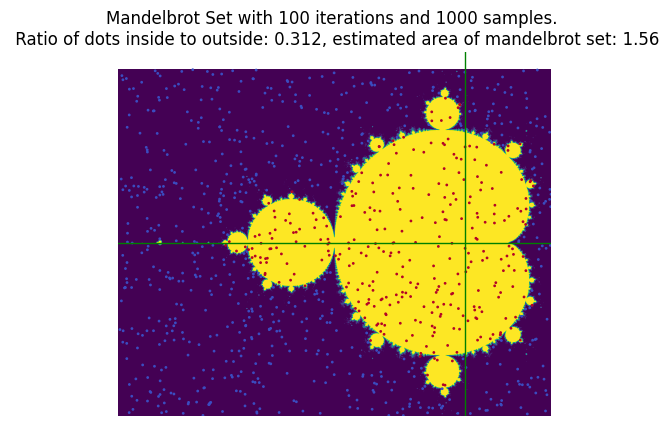

Number of iterations: 100
Number of samples: 10000
Ratio of in to out for randomly selected points: 0.304
Estimated area of mandelbrot set: 1.52


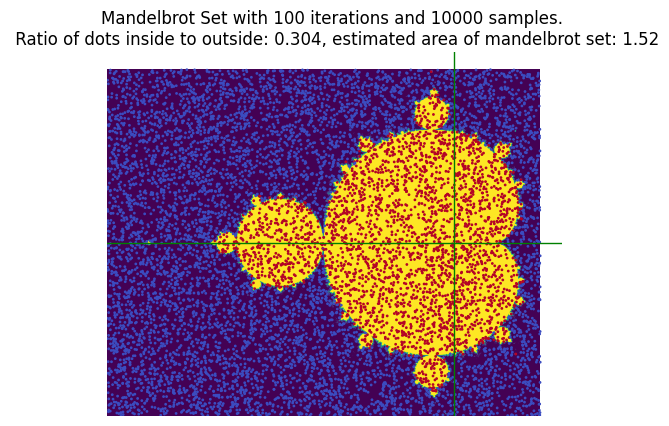

Number of iterations: 200
Number of samples: 1000
Ratio of in to out for randomly selected points: 0.326
Estimated area of mandelbrot set: 1.63


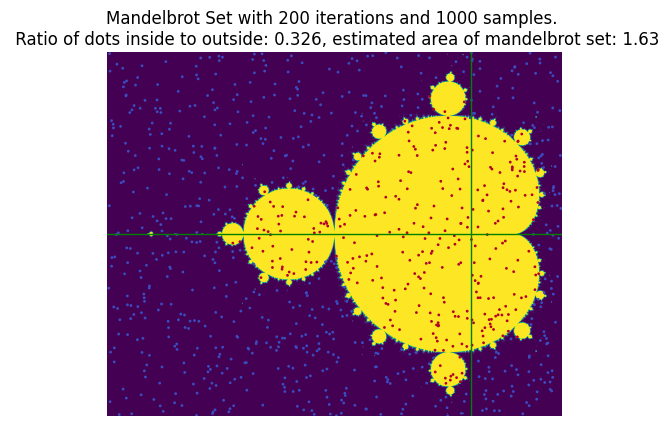



data results (iterations, samples, ratio of in to out dots, estimated area, and photo name) has been saved in data_results.txt


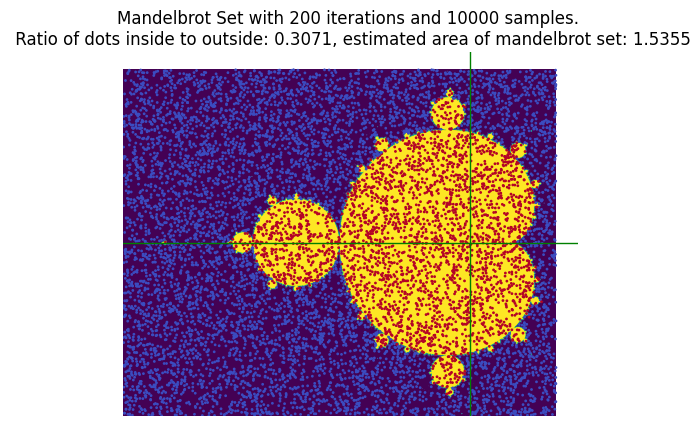

In [23]:
x_min = -2
x_max = 0.5
y_min = -1
y_max = 1
pixel_density = 1000
data_results = []
c_m = complex_matrix(x_min, x_max, y_min, y_max, pixel_density)
number_iterations = [100, 200] #, 200, 300, 400, 500]
number_samples = [100] #, 2000, 3000, 4000, 5000]

for i in range(len(number_iterations)):
    for j in range(len(number_samples)):
        print("Number of iterations:", number_iterations[i])
        print("Number of samples:", number_samples[j])
        ratio, area = calculate_i_s(c_m, number_iterations[i], number_samples[j], x_min, x_max, y_min, y_max, pixel_density, print_image = True, save_image = True)
        data_results.append([number_iterations[i], number_samples[j], ratio, area])
        print('\n')

file = open('data_results.txt','w')
file.write('Number of iterations, Number of samples, Ratio of in to out, Estimated area of mandelbrot set, Saved Photo Name\n')
for item in data_results:
    file_name = str(item[0]) + '_' + str(item[1]) + '_' + str(item[3]) + '.png'
    file.write(str(item[0])+', ' + str(item[1]) + ', ' + str(item[2]) + ', ' + str(item[3]) + ', ' + file_name + '\n')
file.close()
print("data results (iterations, samples, ratio of in to out dots, estimated area, and photo name) has been saved in data_results.txt")